In [1]:
%matplotlib inline

In [2]:
import datetime
import pandas as pd

import matplotlib.pyplot as plt
plt.style.available
plt.style.use("seaborn-whitegrid")

import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette('mako')

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import display_html

#function to display dataframes side-by-side
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style = "display:inline"'),raw=True)


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict

import surprise

from surprise import Dataset, Reader
from surprise import accuracy
from surprise import SVD

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

<h1><center>Movie Recommender Systems - Analysis and Performance</center></h1>
    
<h3><center>Author: Tihomir Todorov</center></h3>

### Table of Contents

1. [Overview](#overview)
    1. [Types of Recommender Systems](#rec_system_types)
    2. [Benefits](#benefits)
    3. [Project Objectives](#objectives)
2. [Exploratory Data Analysis](#EDA)
3. [Data Sampling](#sampling)
4. [Evaluation Metrics](#evaluation)
5. [Performance Tests](#performance_tests)
    1. [Testing the Content-Based Model](#cb_test)
    2. [Testing the Collaborative Filtering Model](#cf_test)
6. [Content-Based Filtering: Implementation](#cb_filtering)
7. [Collaborative Filtering: Implementation](#cf_filtering)
8. [Conclusions](#consclusions)
9. [Resources](#resources)

 <a name="overview"></a>
 ## 1. Overview
 
 ### What is a Recommender System?


A recommender system is a subclass of [Information filtering Systems](https://en.wikipedia.org/wiki/Information_filtering_system) that seeks to predict the rating or the preference a user might give to an item. In simple words, it is an algorithm that suggests relevant items to users. Eg: to suggest for you which books to buy (**Amazon**), which movies to watch (**Netflix**), which song to listen to (**Spotify**), where to go to holidays (**Booking**), and many, many others. </span>


<a name="rec_system_types"></a>
### A. Types of Recommender Systems

There are three main types of recommendation engines: **collaborative filtering**, **content-based filtering** – and a **hybrid** of the two.

<a href="https://imgur.com/IdwJEjw"><img src="https://i.imgur.com/IdwJEjw.png" title="source: imgur.com" width="700px"/></a>
<br></br>

1. *Content-based systems*: Content-based filtering works on the principle that if you like a particular item, you will also like this other item. To make recommendations, algorithms use a profile of the customer’s preferences and a description of an item (genre, product type, color, word length) to work out the similarity of items using [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) and [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).  
    The downside of content-based filtering is that the system is limited to recommending products or content similar to what the person is already buying or using. It can’t go beyond this to recommend other types of products or content. For example, it couldn’t recommend products beyond homeware if the customer had only brought homeware.
<br></br>    

2. *Collaborative filtering systems*: focuses on collecting and analyzing data on user behavior, activities, and preferences, to predict what a person will like, based on their similarity to other users.
    To plot and calculate these similarities, collaborative filtering uses a matrix style formula. An advantage of collaborative filtering is that it doesn’t need to analyze or understand the content (products, films, books). It simply picks items to recommend based on what they know about the user.
<br></br>    

3. A *hybrid recommendation engine*: looks at both the meta (collaborative) data and the transactional (content-based) data. Because of this, it outperforms both.
    In a hybrid recommendation engine, natural language processing tags can be generated for each product or item (movie, song), and vector equations used to calculate the similarity of products. A collaborative filtering matrix can then be used to recommend items to users depending on their behaviors, activities, and preferences. Netflix is the perfect example of a hybrid recommendation engine. It takes into account both the interests of the user (collaborative) and the descriptions or features of the movie or show (content-based). 
<br></br>



<a name="benefits"></a>
### B. Benefits

In this section I will share with you my opinion on what are some of most important benefits of a recommender system:


1. **Drive Traffic**: Through personalized email messages and targeted ads, a recommendation engine can encourage elevated amounts of traffic to your site, thus increasing the opportunity to scoop up more data to further enrich a customer profile.
<br></br>
2. **Deliver Relevant Content**: By analyzing the customer’s current site usage and previous browsing history, a recommendation engine can deliver relevant product recommendations as he or she shops based on said profile.
<br></br>   
3. **Engage Shoppers**: Through individualized product recs, customers are able to delve more deeply into your product line without having to dive into (and very likely get lost in) an e-commerce rabbit hole.
<br></br>    
4. **Convert Shoppers to Customers**: Personalized interactions from a recommendation engine show your customer that he or she is valued as an individual, in turn, engendering long-term loyalty.
<br></br>    
5. **Increase Average Order Value**: Average order values typically rise when an engine is leveraged to display personalized options as shoppers are more willing to spend generously on items they thoroughly covet.
<br></br>    
6. **Control Merchandising and Inventory Rules**: A recommendation engine can add your marketing and inventory control directives to a customer’s profile to feature products that are on clearance or overstocked so as to avoid unnecessary shopping friction.
<br></br>    
7. **Reduce Workload and Overhead**: The volume of data required to create a personal shopping experience for each customer is usually far too large to be managed manually. Using a recommender system automates this process, easing the workload for the IT staff.
<br></br>
8. **A Recommendation Engine Provides Reports**: Accurate and up-to-the-minute reporting will allow you to make informed decisions about the direction of a campaign or the structure of a product page.

Etc...

<a name="objectives"></a>
### C. Project Objectives

 1. To give good recommendations for all of the users. Because there is so much more information on an active user compared to a new user, I cannot use the same model to give recommendations for all of them. Therefore, I will intend to provide a suitable model for each user.
 

2. I wish to optimize the accuracy, which will be measured primarily using root-mean square error (RMSE), and thus I will be performing the methods on a sampled dataset in order to test thoroughly and efficiently.


3. The users will be divided in three categories - new, moderate, and active users, this will be determined based on a threshold number of movies watched and rated on the platform. Providing recommendations for all different types of users is key into optimizing revenue and user experience. 


4. In addition, the list of recommendations will contain movies that have an average rating above a specific threshold, because I do not want to recommend movies that while popular, are not good movies. Customer satisfaction must be number one priority, and the recommended movies serve to provide customers with movies they can enjoy.

<a name="EDA"></a>
## 2. Exploratory Data Analysis

Before we commence with the implementations, let's first introduce our data and gather some insight. We will be working with the **MovieLens Latest (Small) Dataset**, provided by GroupLens:

- This describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100,836 ratings and 3,683 tag applications across 9,742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


- Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. Download this and bigger datasets [here](https://grouplens.org/datasets/movielens/). 


- I've decided to use the smallest dataset available although I'm very aware that the tests and the predictions will be away from reality. If you have a better machine than mine (which you most probably do) tweak the settings of the functions, and use a larger dataset to fit your needs.

In [3]:
'''
Let's begin by loading the data into dataframes.
'''
movies_df = pd.read_csv('movies.csv')

ratings_df = pd.read_csv('ratings.csv')

In [4]:
'''This is how the dataframes look like'''

display(movies_df.head(1), ratings_df.head(1))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [5]:
'''
Now, I'll perform some data corrections
and remove the 'timestamp' column from the datasets
as it is not going to be used in my analysis.

Next step is to merge some of the variables of the
different datasets and create movie_df and user_df dataframes.
'''

ratings_df = ratings_df.drop('timestamp', axis = 1)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

users_df = ratings_df.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
avg_rating = ratings_df.groupby('userId').mean()['rating']

users_df['average_rating'] = avg_rating
users_df = users_df.reset_index()

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

movie_df = ratings_df.groupby('movieId').count()[['userId']].rename(columns={'userId':'ratings_count'})
avg_movie_rating = ratings_df.groupby('movieId').mean()['rating']

movie_df['average_movie_rating'] = avg_movie_rating
movie_df = movie_df.reset_index()

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

print(f"[---- Average User Rating ----][------ Average Movie Rating ------]")
display_side_by_side(users_df.head(), movie_df.head())


[---- Average User Rating ----][------ Average Movie Rating ------]


,userId,ratings_count,average_rating
0,1,232,4.366379
1,2,29,3.948276
2,3,39,2.435897
3,4,216,3.555556
4,5,44,3.636364
,movieId,ratings_count,average_movie_rating
0,1,215,3.920930
1,2,110,3.431818
2,3,52,3.259615
3,4,7,2.357143


In [6]:
print(f'There are {len(movie_df)} movies and {len(ratings_df)} ratings in this dataset.\n')
print(f"[--- 33% Percentile: {np.percentile(users_df['ratings_count'], 33)} ---]") 
print(f"[--- 66% Percentile: {np.percentile(users_df['ratings_count'], 66)} ---]")

There are 9724 movies and 100836 ratings in this dataset.

[--- 33% Percentile: 44.0 ---]
[--- 66% Percentile: 123.0 ---]


- The 33th percentile of the number of movies each user rated is at 44, therefore I will set new users to those who have rated less than 44 movies.


- The 66th percentile is at 123, making (in my opinion) moderate users those who have rated between 44 and 123 movies. 


- Active users will be those in the dataset that have rated greater than 123 movies.


#### Note: In this dataset all users have at least 20 ratings, so the test results (especially for new users) must be taken with a pinch of salt ;)

,Count
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791
0.5,1370


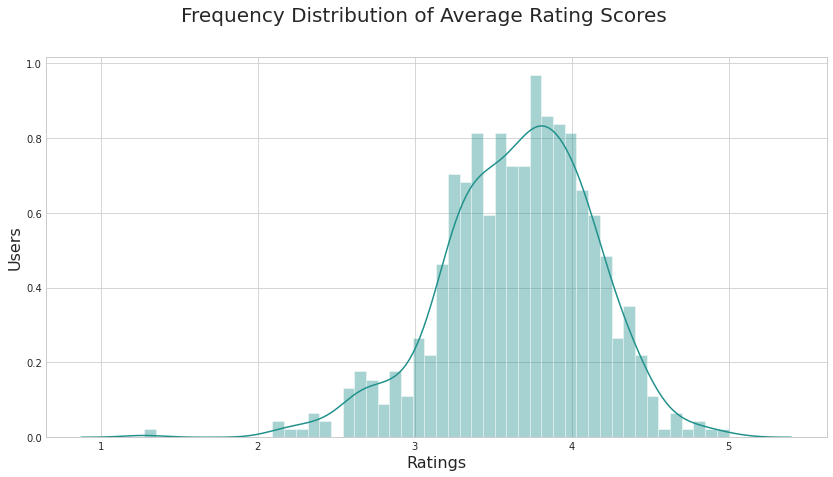

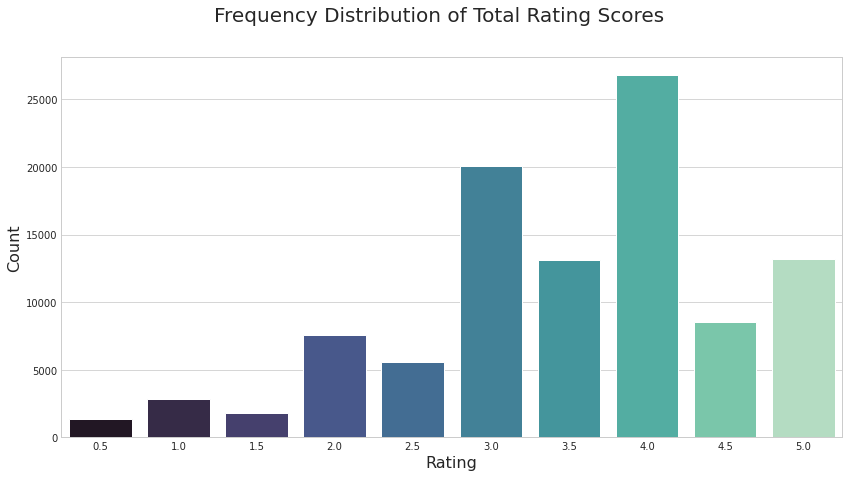

In [7]:
'''Plotting the distribution of ratings given in the ratings dataset'''

plt.figure(figsize=(14, 7))

sns.distplot(users_df["average_rating"], color = '#21918c', bins = 50)

plt.xlabel('Ratings', fontsize = 16)
plt.ylabel('Users', fontsize = 16)

plt.suptitle("Frequency Distribution of Average Rating Scores", fontsize = 20)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
fig, ax = plt.subplots(figsize = (14,7))
sns.countplot(ratings_df.rating, palette='mako')

ax.set_xlabel('Rating', fontsize = 16)
ax.set_ylabel('Count',fontsize = 16)

plt.suptitle('Frequency Distribution of Total Rating Scores', fontsize = 20)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

ratings_count_df = pd.DataFrame(ratings_df.rating.value_counts().sort_values(ascending=False)).rename(columns = {'rating' : 'Count'})
ratings_percentile_df = pd.DataFrame(ratings_df.rating.value_counts(normalize=True)).rename(columns = {'rating' : '% of Total'})
ratings_variability_df = pd.DataFrame(ratings_df.rating.describe()).rename(columns = {'rating' : 'Variability'})

display_side_by_side(ratings_count_df, ratings_percentile_df, ratings_variability_df)


- The 2 plots are quite similar. I can see that more people give whole value numbers rather than halves.


- I can also conclude that the most prevalent ratings given are 4.0, and 3.0 with 5.0 coming in third. Also people were less likely to give low ratings as evidenced by the low number of movies rated between 0.5 and 2.5.


- Most people's average ratings are around 3 to 4. Hence, when I determine whether or not a recommendation is "good", I will only consider values equal or greater than 3. This boundary will determine the accuracy in future parts of the project.

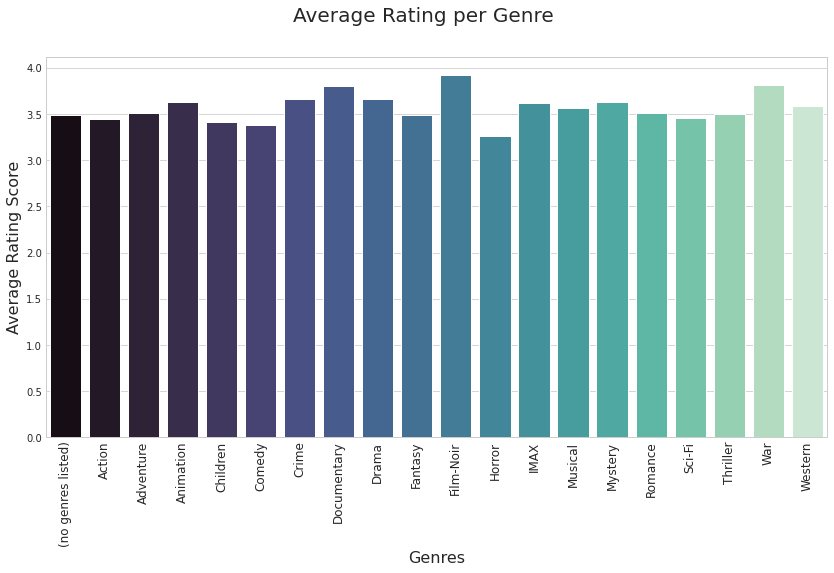

,Genre,AVG Rating
10,Film-Noir,3.920115
18,War,3.808294
7,Documentary,3.797785
6,Crime,3.658294
8,Drama,3.656184


In [8]:
'''As a next step in our analysis let's calculate the average rating per genre'''

movie_ratings_df = pd.merge(movies_df, ratings_df)
genre_ratings_df = movie_ratings_df.loc[:,['genres', 'rating']]
genre_ratings_df = genre_ratings_df.set_index(genre_ratings_df.columns.drop('genres',1).tolist()).genres.str.split('|', expand=True).stack().reset_index().rename(columns={0:'genres'}).loc[:, genre_ratings_df.columns]

genre_mean_rating_df = pd.DataFrame(genre_ratings_df.groupby('genres')['rating'].mean()).reset_index()


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x = 'genres', y = 'rating', data = genre_mean_rating_df, palette='mako')


ax.tick_params(axis='x', labelsize= 12, rotation=90)

ax.set_xlabel('Genres', fontsize= 16)
ax.set_ylabel('Average Rating Score',fontsize= 16)

plt.suptitle("Average Rating per Genre", fontsize=20)

plt.show()

ratings_per_genre = pd.DataFrame(genre_mean_rating_df).sort_values(by='rating', ascending=False).rename(columns = {'genres' : 'Genre', 'rating' : 'AVG Rating'})

display(ratings_per_genre.head())

- The top 5 genres with the highest average ratings in this dataset are Film-Noir, War, Documentary, Crime and Drama.

In [9]:
'''Getting the census of the genre keywords'''

genre_labels = set()

for genre in movies_df['genres'].str.split('|').values:
    genre_labels.update(genre)


def keyword_count(dataset, column, keywords):
    keyword_dict = {key:0 for key in keywords}
    for genre in dataset[column].str.split('|'):                
        for key in [key for key in genre if key in keywords]: 
            if pd.notna(key): 
                keyword_dict[key] += 1

    keyword_occurences = []
    for key, value in keyword_dict.items():
        keyword_occurences.append([key, value])
    
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    
    return keyword_occurences, keyword_dict

# Calling this function gives access to a list of genre keywords which are sorted by descending order of frequency

keyword_occurences, keyword_dict = keyword_count(movies_df, 'genres', genre_labels)
keyword_df = pd.DataFrame(keyword_occurences).rename(columns = {0 : 'Genre', 1 : 'Occurrences'})

- The dataframe above shows the prevalence of genres in the dataset. I can clearly cofirm the results of my function. 


- Below I will visualize the Top 10 genres by popularity.

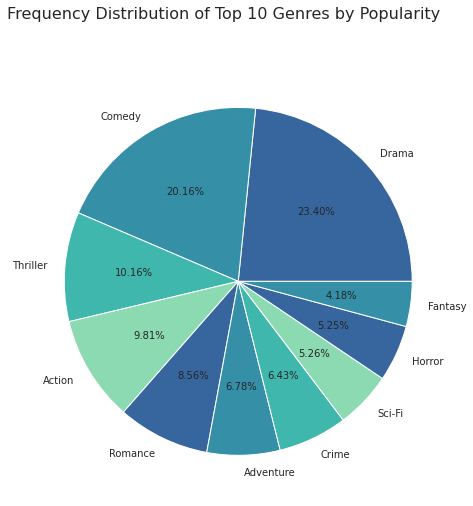

In [10]:
fig, ax = plt.subplots(figsize = (16,8))


labels = [label for label, occ in keyword_occurences[0:10]]
colors_pie = sns.color_palette('mako')[2:6]

plt.pie(keyword_df.Occurrences[0:10], labels = labels, colors= colors_pie, autopct='%.2f%%')
plt.suptitle('Frequency Distribution of Top 10 Genres by Popularity', fontsize = 16)

plt.show()


### Summary:

- I've explored the MovieLens small dataset which helped me better understand the data. The reason for the heavy reliance on graphics is that by its very nature the main role of EDA is to open-mindedly explore, and graphics gives the analysts the power to do so.

<a name="sampling"></a>
## 3. Data Sampling

 - The method below finds the list of users that fall under the new, moderate, and active users category by splitting them up into three different dataframes based on the thresholds found above. 
 
 
 - I will use users who have rated less than 44 movies for new users, 44 to 123 movies for moderate users, and greater than 123 movies for active users. 
 
 
 - In order to implement the dataset for our model, I will take 200 users from each of the groups of users, such that overall I will be testing on all 600 users (almost all of the dataset), and an equal amount of users from each category will have recommended movies. 
 
 
- After finding the users for each user category, I will split up the data into three different dataframes, keeping all the data for each user, such that I can keep the distinction between each user group.



In [11]:
'''
In order to avoid confusion with the previous section 
I will begin by loading the data anew and preparing it for my current needs.
'''

data = pd.read_csv('ratings.csv')
data = data.drop(columns=['timestamp'])

user_df = data.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
avg_rating = data.groupby('userId').mean()['rating']

user_df['average_rating'] = avg_rating
user_df = user_df.reset_index()

In [12]:
def categorize_users(data):
    
    new_users = user_df[user_df['ratings_count'] > 0]
    new_users = new_users[new_users['ratings_count'] <= 44].reset_index()['userId']
    mod_users = user_df[user_df['ratings_count'] > 44]
    mod_users = mod_users[mod_users['ratings_count'] <= 123].reset_index()['userId']
    active_users = user_df[user_df['ratings_count'] > 123].reset_index()['userId']
    
    new_users = new_users.sample(n=200, random_state =1)
    mod_users = mod_users.sample(n=200, random_state =1)
    active_users = active_users.sample(n=200, random_state =1)
    
    new_users_data = data[data['userId'].isin(new_users)]
    mod_users_data = data[data['userId'].isin(mod_users)]
    active_users_data = data[data['userId'].isin(active_users)]
    
    return new_users_data, mod_users_data, active_users_data


new_users_data, mod_users_data, active_users_data = categorize_users(data)

In [13]:
print(f"Total amount of ratings for New  users: {len(new_users_data)}")
print(f"Total amount of ratings for Mod. users: {len(mod_users_data)}")
print(f"Total amount of ratings for Act. users: {len(active_users_data)}")

Total amount of ratings for New  users: 5900
Total amount of ratings for Mod. users: 15076
Total amount of ratings for Act. users: 76882


- Next I will split each user category into 80/20 training and testing data, and then concatenate the training dataframes together and the testing dataframes together in order to create input for baseline models. 


- The method in which I will split train and test is very important for judging the plausibility of the model. Due to the nature of my recommendation system, I need to have the same number of users in both train and test. 


- In addition, they need to have enough ratings for us to properly train and test our model. In my case, using such a limited amount of data, it will be difficult to call the results relevant.

In [14]:
y_new = new_users_data['rating']
x_new = new_users_data[[c for c in new_users_data.columns if c != 'rating']]
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x_new, y_new, test_size=0.2, 
                            random_state = 1, stratify=new_users_data.userId)

y_mod = mod_users_data['rating']
x_mod = mod_users_data[[c for c in mod_users_data.columns if c != 'rating']]
mod_x_train, mod_x_test, mod_y_train, mod_y_test = train_test_split(x_mod, y_mod, test_size=0.2, 
                            random_state = 1, stratify=mod_users_data.userId)

y_active = active_users_data['rating']
x_active = active_users_data[[c for c in active_users_data.columns if c != 'rating']]
active_x_train, active_x_test, active_y_train, active_y_test = train_test_split(x_active, y_active, test_size=0.2, 
                            random_state = 1, stratify=active_users_data.userId)

'''combine all user data to create one training and one testing dataframe'''

new_training = pd.concat([new_x_train, new_y_train], axis=1)
new_testing = pd.concat([new_x_test, new_y_test], axis=1)
moderate_training = pd.concat([mod_x_train, mod_y_train], axis=1)
moderate_testing = pd.concat([mod_x_test, mod_y_test], axis=1)
active_training = pd.concat([active_x_train, active_y_train], axis=1)
active_testing = pd.concat([active_x_test, active_y_test], axis=1)


train = new_training.append([moderate_training, active_training])
test = new_testing.append([moderate_testing, active_testing])

In [15]:
print("Number of Users:", train['userId'].nunique())
print("Number of Movies:", train['movieId'].nunique() + test['movieId'].nunique())
print("Number of Ratings in Train:", len(train))
print("Number of Ratings in Test:", len(test))

Number of Users: 600
Number of Movies: 13885
Number of Ratings in Train: 78285
Number of Ratings in Test: 19573


<a name="evaluation"></a>
## 4. Evaluation Metrics 

### 1. RMSE

- Our **primary** evaluation metric is [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). Root Mean Square Error is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 

The formula is:

$$RMSE = \sqrt {\frac{1}{N} \sum_{i=1}^{N} (P_i} - O_i)^2$$

where:

- P is the predicted value

- O is the observed or actual value

- (Pi - Oi) are the differences between predicted and observed values squared

- N is the total sample size
    
Therefore:

- RMSE is the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of the residuals


- RMSE indicates average model prediction error


- The lower values indicate a better fit


- It is measured in same units as the Target variable

<br></br>

### 2. Precision & Recall @ K

- The **secondary** evaluation metric is the ranking metric: [Rrecision and Recall @ k](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54).  Precision measures the truly relevant recommendations out of everything recommended. Recall represents the truly relevant recommendations out of all relevant items. We are measuring these values at the top 10 recommendations for each user. 


- Precision is a good evaluation metric for movie recommendations because the cost of a false positive is very high and the cost of a false negative is low. We do not want to give a wrong strong recommendation for a movie, that would be worse than missing a good movie to recommend. We consider a rating of 3.5 and above to be a "good" rating. 


- From the analyses done in our exploratory section, we determine that majority of the ratings are around 3-4, with around the top 25% of the ratings 4 or higher. Therefore, for users to consider a movie good, or one of the top movies out of the movies they've rated, we set the cutoff at 3.5 to distinguish it as good.
<br></br>

### 3. Coverage @ K


- The **third** evaluation metric is user/item [Coverage @ k](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093#:~:text=the%20other%20models.-,Coverage,nearly%20100%25%20coverage%20as%20expected.). For user coverage, it was defined as the percentage of users in the test set that had all their items in the top-10 recommended items given by the algorithm. For item coverage, it was defined as the percentage of items in the training set that was actually recommended to users in the test set.
<br></br>

### 4. NDCG

$$NDCG_{@k} = \frac{DCG_@K}{IDCG_@K}$$


- [NDCG](https://machinelearninginterview.com/topics/machine-learning/ndcg-evaluation-metric-for-recommender-systems/#:~:text=What%20is%20the%20NDCG%20metric,well%20a%20recommender%20system%20works.) measures the relevance of an item based on its position in the results. The gain is highest at the top of the results list, where the gain continues to get discounted at every lower rank. IDCG, or ideal discounted cummulative gain, is found by producing the maximum possible DCG for each user. Therefore, NDCG, normalized discounted cummulative gain, is normalized across each user, meaning that the DCG is divided by the IDCG. The highest NDCG is 1, where the DCG is equal to the IDCG, and therefore the higher the NDCG, typically the better our ranking system is.

## Evaluation

- Before building my models I will define the evaluation functions that I will use later.

In [16]:
'''RMSE & Mae'''

def get_rmse(pred, original):
    rmse = (sum((pred-original)**2)/len(pred)) ** (1/2)
    return rmse

#additional error metric
def get_mae(pred, original):
    mae = sum(abs(original - pred)) / len(pred)
    return mae

In [17]:
'''Precision and Recall @ K'''

def precision_recall_at_k(predictions, k=10, threshold=3):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for index, row in predictions.iterrows(): 
        uid = row['userId']
        user_est_true[uid].append((row['prediction'], row['rating']))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. I set it here to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. I set it here to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [18]:
'''Coverage @ K'''

def get_top_recs_cb(ratings, n):
    #returns the top n recommendations 
    top_recs = {}
    
    for index, row in ratings.iterrows():
        if row['userId'] not in top_recs.keys():
            top_recs[row['userId']] = [(row['movieId'], row['prediction'], row['rating'])]
        else:
            top_recs[row['userId']].append((row['movieId'], row['prediction'], row['rating']))
    
    # sort the preds for each user and get the n highest ones.
    for user, ratings in top_recs.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_recs[user] = ratings[:n]

    return top_recs


def user_coverage(top_recs, k):
    user_cov = {}
    tot = 0
    for user in top_recs:
        user_cov[user] = []
        for ratings in top_recs[user]:
            if ratings[2] >= 3:
                user_cov[user].append(ratings[0])
        if len(user_cov[user]) >= k:
            tot += 1
    return tot


def item_coverage(top_recs, k):
    item_cov = {}
    tot = 0
    for user in top_recs:
        for ratings in top_recs[user]:
            if ratings[0] not in item_cov.keys(): 
                item_cov[ratings[0]] = [] 
            if ratings[2] >= 3:
                item_cov[ratings[0]].append(ratings[0])  
                
    for item in item_cov:
        if len(item_cov[item]) >= k:
            tot += 1        
    return tot, item_cov

In [19]:
'''NDCG'''

def ndcg_at_k(predictions, k=10):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    ndcgs = [] 
    for index, row in predictions.iterrows(): 
        uid = row['userId']
        user_est_true[uid].append((row['prediction'], row['rating']))
        
    def dcg_at_k(user_ratings, user_preds, k=10):
        # Sort user ratings by estimated value
        user_preds = np.argsort(user_preds)[::-1]
        user_ratings = np.take(user_ratings, user_preds[:k])
        user_ratings = np.array(user_ratings)
        num = 2 ** user_ratings - 1
        den = np.log2(np.arange(2, num.size + 2))
        dcg = np.sum(num/den)
        return dcg
        
    for uid, scores in user_est_true.items():
        user_preds = [x[0] for x in scores]
        user_ratings = [x[1] for x in scores]
        dcg = dcg_at_k(user_ratings, user_preds)
        idcg = dcg_at_k(user_ratings, user_ratings)
        ndcg = dcg/idcg
        ndcgs.append(ndcg)
    
    avg_ndcg = sum(ndcgs)/len(ndcgs) 
    return avg_ndcg

- Now I'm ready to begin testing!

<a name="performance_tests"></a>
## 5. Performance Tests 

<a name="cb_test"></a>
### A. Testing the Content Based Model 


- I chose to use a content based model to provide top movie recommendations for the new user category, or more specifically those who have rated between 1 to 35 movies. For testing purposes, however, I've increased increased the minimum number of ratings to 5 to create a viable train and test split. 


- Given the fact that this category has limited information about the users and their preferences, Ive decided that a content based model would be the most appropriate as the model would focus on the content that the user has watched and liked/disliked previously, and try to recommend movies similar to the previous content. 


- With this method, the model will not need data from any other users, and can recommend specific to user interest, optimizing the recommendations for users we do not have much information about.


- I believe this model would be a possible solution to the "Cold Start" problem.

### Preprocessing

- In the new user preprocessing method, I will take in the new users data frame and split it into a train and test set that can be inputted into the model to make predictions. 


- I will split the data with an 80/20 split. In addition, this method takes in a movie data dataset, and converts its genres to a list of strings such that it can be correctly inputted into the TFIDF vectorizer.



In [20]:
movies_data = pd.read_csv('movies.csv')

In [21]:
def new_user_preprocessing(new_user_data, movie_data):
    y_new = new_users_data['rating']
    x_new = new_users_data[[c for c in new_users_data.columns if c != 'rating']]
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x_new, y_new, test_size=0.2, 
                                random_state = 1, stratify=new_users_data.userId)
    
    new_training = pd.concat([new_x_train, new_y_train], axis=1)
    new_testing = pd.concat([new_x_test, new_y_test], axis=1)
    
    movie_data['genres'] = movie_data['genres'].str.split('|')
    movie_data['genres'] = movie_data['genres'].fillna("").astype('str')
    
    return new_training, new_testing, movie_data

In [22]:
training_nu, test_nu, movie_data = new_user_preprocessing(new_training, movies_data)

In [23]:
'''The Model'''

def content_based_model(movie_data, train, test, alpha):
    #item profile
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tf_matrix = tfidf.fit_transform(movie_data['genres'])
    tfidf_data = pd.DataFrame(tf_matrix.todense(), columns = tfidf.get_feature_names())
    tfidf_data = tfidf_data.set_index(movie_data['movieId'])
    
    visited_users = [] 
    movie_list = []
    preds = []
    original = [] 
    predicted_ratings = pd.DataFrame() 
    
    for user in test.userId.unique():
        if user in visited_users: 
            continue
        
        toPredict = test[test['userId'] == user]
        
        #user profile 
        ratings_user = train[train['userId'] == user]
        if ratings_user.empty:
            continue 
        
        user_genre = tfidf_data.loc[list(ratings_user['movieId'])]
        
        #build model for each user 
        reg = Ridge(alpha = alpha)
        reg.fit(user_genre, ratings_user['rating'])
        
        original = original + list(toPredict['rating'])
        visited_users = visited_users + ([user] * len(toPredict))
        movie_list = movie_list + list(toPredict['movieId'])
        #to_test = tfidf_data.loc[list(toPredict['movieId'])]
        predictions = list(reg.predict(tfidf_data.loc[list(toPredict['movieId'])])) 
        preds = preds + predictions
        
    predicted_ratings['userId'] = visited_users
    predicted_ratings['movieId'] = movie_list
    predicted_ratings['rating'] = original
    predicted_ratings['prediction'] = preds
    
    return predicted_ratings 

In [24]:
predicted_ratings = content_based_model(movie_data, training_nu, test_nu, 1)

### Testing

In [25]:
'''RMSE'''

rmse_cb = get_rmse(predicted_ratings['rating'], predicted_ratings['prediction'])

In [26]:
'''Precision and Recall @ K'''

precisions_cb, recalls_cb = precision_recall_at_k(predicted_ratings, k=10, threshold=3.5)

avg_cb_precision = sum(precisions_cb.values()) / len(precisions_cb)
avg_cb_recall = sum(recalls_cb.values()) / len(recalls_cb)

In [27]:
'''Coverage @ K'''

top_recs_cb_test = get_top_recs_cb(predicted_ratings, 10)
user_cov_test_cb = user_coverage(top_recs_cb_test, 1) / len(top_recs_cb_test)

item_cov_ts_cb, item_dict_ts_cb = item_coverage(top_recs_cb_test, 1)
item_cov_test_cb = item_cov_ts_cb / len(item_dict_ts_cb)

In [28]:
'''NDCG'''

avg_ndcg_cb = ndcg_at_k(predicted_ratings)

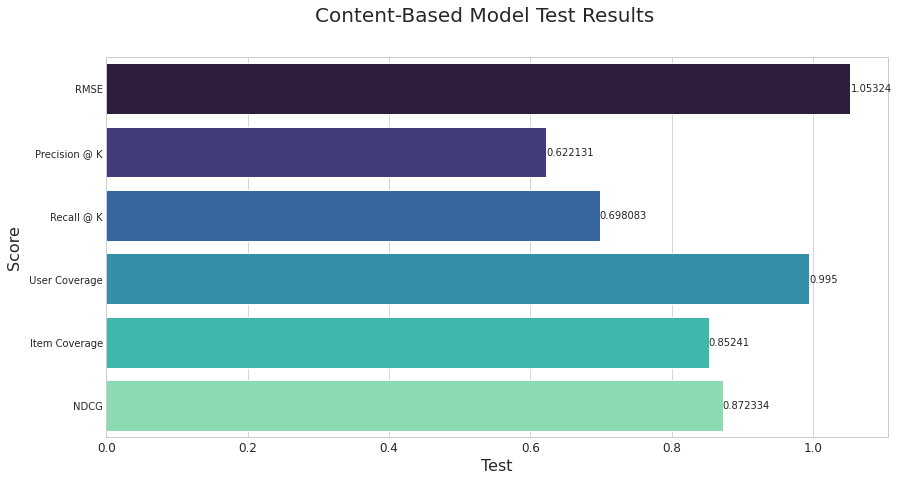

In [29]:
'''Now let's plot the results'''

test_dict_base = {'Evaluation': ['RMSE', 'Precision @ K', 'Recall @ K', ' User Coverage', 'Item Coverage', 'NDCG'], 
                  'Score': [rmse_cb, avg_cb_precision, avg_cb_recall, user_cov_test_cb, item_cov_test_cb, avg_ndcg_cb]}  

cb_test_df = pd.DataFrame(test_dict_base)
fig, ax = plt.subplots(figsize=(14, 7))

bar_base = sns.barplot(x = 'Score', y = 'Evaluation', data = cb_test_df, palette='mako', saturation=1.5)

for i in bar_base.containers:
    bar_base.bar_label(i,)
    
ax.tick_params(axis='x', labelsize = 12)
ax.set_xlabel('Test', fontsize= 16)
ax.set_ylabel('Score',fontsize= 16)

plt.suptitle("Content-Based Model Test Results", fontsize=20)

plt.show()

<a name="cf_test"></a>
### B. Testing the Collaborative Filtering Model

- Another baseline that I will implement is the collaborative filtering baseline. Collaborative filtering works on past user behavior without any context so we think it would provide a valuable baseline for our other models. 


- The following implementation of item-based CF makes recommendations based on similarity between items calculated from user ratings of those items. I will create a Movie X Movie matrix and try to predict the ratings a user will give a movie based on the previous ratings they have given. 


- In addition, item based CF would be more suitable for a platform where the increase of new movies is much slower than the increase of new users. When we get a new user, we do not need to recalculate user to user similarity like we need for user-based CF. 

### Preprocessing

In [30]:
def get_model_ib(training_df):
    moviescales = Reader(rating_scale=(0.5, 5.0))
    data_training = Dataset.load_from_df(training_df[['userId', 'movieId', 'rating']], moviescales)    
    trainset = data_training.build_full_trainset()
    svd = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)
    svd.fit(trainset)
    return svd


def get_predictions(model, test_df):
    preds = [] 
    for index, row in test_df.iterrows(): 
        pred = model.predict(row['userId'], row['movieId'], r_ui=row['rating'], verbose=False)
        preds.append(pred.est)
    
    return preds

In [31]:
'''Using predictions on test dataset from this model for model evaluation.'''

cf_model = get_model_ib(train)
cf_preds = get_predictions(cf_model, test)

### Testing

In [32]:
'''RMSE'''
rmse_cf = get_rmse(cf_preds, test['rating'])

In [33]:
'''Precision and Recall @ K'''

cf_test_preds = test
cf_test_preds['prediction'] = cf_preds

precisions_cf, recalls_cf = precision_recall_at_k(cf_test_preds, k=10, threshold=3.5)

avg_cf_precision = sum(precisions_cf.values()) / len(precisions_cf)
avg_cf_recall = sum(recalls_cf.values()) / len(recalls_cf)

In [34]:
'''Coverage @ K'''

toprecs_cf_test = get_top_recs_cb(cf_test_preds, 10)
user_cov_test_cf = user_coverage(toprecs_cf_test, 1) / len(toprecs_cf_test)

item_cov_ts_cf, item_dict_ts_cf = item_coverage(toprecs_cf_test, 1)
item_cov_test_cf = item_cov_ts_cf / len(item_dict_ts_cf)

In [35]:
'''NDCG'''

avg_ndcg_cf = ndcg_at_k(cf_test_preds)

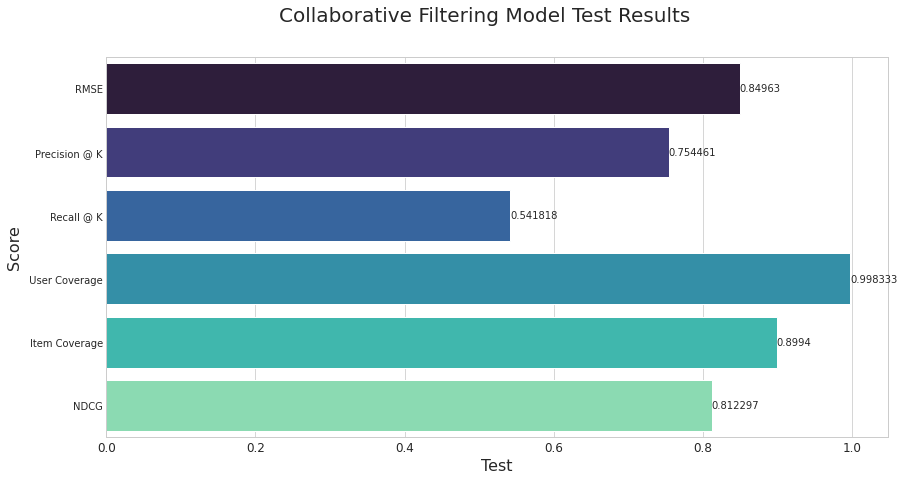

In [36]:
'''Now let's plot the results'''

test_dict_base = {'Evaluation': ['RMSE', 'Precision @ K', 'Recall @ K', ' User Coverage', 'Item Coverage', 'NDCG'], 
                  'Score': [rmse_cf, avg_cf_precision, avg_cf_recall, user_cov_test_cf, item_cov_test_cf, avg_ndcg_cf]}  

cf_test_df = pd.DataFrame(test_dict_base)
fig, ax = plt.subplots(figsize=(14, 7))

bar_base = sns.barplot(x = 'Score', y = 'Evaluation', data = cf_test_df, palette='mako', saturation=1.5)

for i in bar_base.containers:
    bar_base.bar_label(i,)
    
ax.tick_params(axis='x', labelsize = 12)
ax.set_xlabel('Test', fontsize= 16)
ax.set_ylabel('Score',fontsize= 16)

plt.suptitle("Collaborative Filtering Model Test Results", fontsize=20)

plt.show()

### Summary

In [37]:
cb_test = cb_test_df.rename(columns={'Score' : 'CB_System'})
cf_test = cf_test_df.rename(columns={'Score' : 'CF_System'})

all_tests_df = cb_test.join([cf_test['CF_System']])
all_tests_df

,Evaluation,CB_System,CF_System
0,RMSE,1.053236,0.849630
1,Precision @ K,0.622131,0.754461
2,Recall @ K,0.698083,0.541818
3,User Coverage,0.995000,0.998333
4,Item Coverage,0.852410,0.899400
5,NDCG,0.872334,0.812297


## Overview


- The above table represents the methods I used in this project. We want to minimize RMSE and maximize the other matrics. 


- When looking at the performances of all the individual models, out of the the content based model, and the collaborative filtering, the collaborative filtering model performs the best. This makes sense because the it had the most amount of information on its users, and therefore, was able to predict the most accuractely, having the lowest RMSE, highest precision and item coverage. The surprising factor was its NDCG, it wasn't able to predict as ideal of a top 10 recommendation as the other model.


- There are many ways I can improve the CF model to eventually completely outperform the content based. Since I've seperated our customers into three groups with three different models, I can analyze each individually to see where to focus on. 


- The content based model targets new users who do not have many rating data on the platform. However, I think its results can be vastly improved if I can use more data for each user and use that context as well. Currently, I can only use genre as the content for each user. If I include user profile information, I would have a lot more freedom for the content based recommendation.


- In conclusion, there is a lot more room for improvement. It would be beneficial to gather more content based data for each user to better recommend movies to the new users. This would not only benefit new user retention, but also provide better analysis for other types of users as well. 

<a name="cb_filtering"></a>
## 6. Content-Based Filtering: Implementation

- In this part I am going to implement the system that is intended to be used for new users and judge it by the relevance of the movies.


- I am going to create a class which uses CountVectorizer from sklearn.feature_extraction.text to transform the combined_features column in mt_ratings into a matrix of token counts and cosine_similarity from sklearn.metrics.pairwise to calculate the cosine similarity on the vectorized column.



- The class will take in the name of one movie that the user likes and recommend a list of movies with the highest cosine similarity based on it.



In [38]:
'''
I will start by importing and preparing the data for the current system,
and use the 'tags.csv' data as well in this system.
'''

movies_cb = pd.read_csv('movies.csv')
ratings_cb = pd.read_csv('ratings.csv')
tags_cb = pd.read_csv('tags.csv')
                         
ratings_cb = ratings_cb.drop('timestamp', axis = 1)
tags_cb = tags_cb.drop('timestamp', axis = 1)
movie_ratings = pd.merge(movies_cb, ratings_cb)
                         
mt_ratings = pd.merge(movie_ratings, tags_cb)
mt_ratings['genres'] = mt_ratings['genres'].apply(lambda x: ''.join(x.replace('|', ' ').lower()))


In [39]:
'''
Creating a new column that takes in the features in genres and tag columns per row
'''
                         
def combined_features(row):
    return row['genres']+" "+row['tag']

mt_ratings["combined_features"] = mt_ratings.apply(combined_features, axis =1)
mt_ratings.reset_index(inplace = True)

'''
This randomly produces a movie title from our dataset to ensure that 
the movie that is in the dataset. Using random_state to ensure reproducible results.
'''
mt_ratings.sample(1, random_state = 42)['title']

2069    Hulk (2003)
Name: title, dtype: object

In [40]:
class ContentBasedRec:

    def __init__(self,name,df):
        self.name = name
        self.df = df
        self.title = df['title']
        self.index = df['index']
        self.combined_features = df['combined_features']
        
        
    def cosine_sim(self):
        
        count_vec = CountVectorizer()
      # convert the contents of the combined features into a matrix of token counts
        count_matrix = count_vec.fit_transform(self.combined_features)
        cosine_sim = pd.DataFrame(cosine_similarity(count_matrix))
        
        return cosine_sim

    def title_index(self):
        
        return self.df[self.title == self.name]["index"].values[0]

    def similar_movies(self):
        self.title_index()
        similar_movies = list(enumerate(self.cosine_sim()[self.title_index()]))
        
        return sorted(similar_movies, key=lambda x:x[1], reverse=True)

    #     using the index of the movies to get the movie titles and recommending the first 15 most similar movies
    def movie_list(self):
        movie_list = []
        for movie in self.similar_movies():
            movie_index = movie[0]
            movie_title = self.df[self.index == movie_index]["title"].values[0]
            if movie_title not in movie_list:
                movie_list.append(movie_title)
            else:
                 pass
            if len(movie_list)==21:

                return movie_list[1:]

In [41]:
'''Let's make some predictions now and see the recommendations for a user that likes Hulk'''

movies_like_hulk  = ContentBasedRec('Hulk (2003)', mt_ratings)

like_hulk_df = pd.DataFrame(movies_like_hulk.movie_list())
like_hulk_df.columns = ['Recommended Movies']

display(like_hulk_df.head(20))

,Recommended Movies
0,Star Wars: Episode IV - A New Hope (1977)
1,Star Wars: Episode V - The Empire Strikes Back...
2,X-Men (2000)
3,Star Trek (2009)
4,Terminator Salvation (2009)
5,Avatar (2009)
6,Star Wars: Episode I - The Phantom Menace (1999)
7,Superman (1978)
8,Superman III (1983)
9,Star Wars: Episode III - Revenge of the Sith (...


## Overview

- I like the fact that the recommendations are from different years, not only the latest movies.


- The movies recommended are definitely fitting the 'like Hulk' description. If I make a search in google.com I get almost 100% the same recommendations.


- This model is good for a possible solution to the Cold Start problem, although we know only that the user is new on the current platform. We don't know if he/she's seen those movies.


- In order to make better predictions to new users, there must be some way to gather more user data, and respond according to it. Otherwise we just make popularity based predictions that can work up to a certain degree.

<a name="cf_filtering"></a>
## 7. Collaborative Filtering: Implementation

- In this section I am going to implement a Model-Based CF, the system that performed the best at the tests, and place myself in the situation of a user that will receive recommendations.


- I've tested 4 different algorithms from the surprise library and I've decided to use **SVD** for it, as it was the one that performed the best. The other 3 are **KNNBaseline**, **KNNWithMeans** and **KNNWithZScore**.


- I've also tested various sim_options and selected the ones that I will implement now as the best performers @ RMSE.

In [42]:
'''
Let's import and clean the data again
From my previous data exploratory report, I find some outliers 
which only rated once and got rating score as high as 5. 
Therefore, I will filter the rating table to only include movies 
which have at least 2 ratings and users who rate at least 5 times.
'''

movies_cf = pd.read_csv('movies.csv')
ratings_cf = pd.read_csv('ratings.csv')


min_movie_ratings = 0 #after seeing that this limits the dataset even more I've decided to set
min_user_ratings =  0 #those parameters to 0 for the time being, will implement with bigger dataset

ratings_flrd_df = ratings_cf.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)


print("{0} movies deleted; all movies are now rated at least: {1} times. Old dim.: {2}; New dim.: {3}" 
      .format(len(ratings_cf.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings_cf.shape, ratings_flrd_df.shape ))

0 movies deleted; all movies are now rated at least: 0 times. Old dim.: (100836, 4); New dim.: (100836, 4)


In [43]:
n_users = ratings_flrd_df['userId'].nunique()
n_items = ratings_flrd_df['movieId'].nunique()

print('Num of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

sparsity=round(1.0 - len(ratings_flrd_df) / float(n_users * n_items), 3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity * 100) + '%')

Num of Users: 610
Num of Movies: 9724
The sparsity level of MovieLens100K is 98.3%


In [44]:
'''Creating a dummy variable to map between the movie id and column index.'''

movie_list = ratings_flrd_df['movieId'].unique()
movie_list.sort()

movie_to_idx = {movie: index for index, movie in enumerate (movie_list)}

- After filtering the dataset, I have to discover the structures. With high-dimentional raw data, it's hard to extract information. I will use matrix factorization to learn the latent preferences of users and the latent attributes of items from known ratings, in order to then predict the unknown ratings through the dot product of the latent features of users and items. 


- Let's train the SVD model and examine the effect of number of latent factors k on the model's performance now.

In [45]:
reader = Reader(rating_scale=(0, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId", "movieId", "rating"]], reader=reader)

- Next step is to do a 5-fold Cross-Validation


- As we train any model on the training set, it tends to overfit or underfit most of the time, and in order to avoid this situation, we use regularization techniques. cross-validation is a good technique to evaluate the estimator performance. To find the best performance of latent factor, I'll use 5 fold cross-validation.

In [46]:
'''define a cross-validation iterator'''

kf = KFold(n_splits = 5)

algo = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)


for trainset, testset in kf.split(data):

    algo.fit(trainset)
    predictions = algo.test(testset)

    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8560
RMSE: 0.8455
RMSE: 0.8501
RMSE: 0.8490
RMSE: 0.8478


- The average result is more or less the same as in the previous tests.

### SVD Recommendation

In [47]:
def get_top_n(predictions, UserID, n = 10):
    
        # uid – The (raw) user id. 
        # iid – The (raw) item id. 
        # r_ui (float) – The true rating 𝑟𝑢𝑖.
        # est (float) – The estimated rating r^𝑢𝑖.
        
    top_n = defaultdict(list)
    for user_id, movie_id, true_r, est_r, detail in predictions:
        top_n[user_id].append((movie_id, est_r))

    # Then sort the predictions for each user by the estimated rating and find top k movie_id
    for user_id, movie_ratings in top_n.items():
        movie_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[user_id] = movie_ratings[: n]
        
        return top_n[user_id]

def recommendation(user_id, predictions):
    
    movie_rating_list = get_top_n(predictions, user_id, n=20)
    preds_list = pd.DataFrame(movie_rating_list, columns=["movieId", "EstRating"])
    preds_df = pd.DataFrame(preds_list.merge(movies_cf, on='movieId', how='left'))[['title', 'genres', 'EstRating']]
    
    print(f'The algorithm recommends the following 20 movies:')
    display(preds_df)
    
    
recommendation(155, predictions)

The algorithm recommends the following 20 movies:


,title,genres,EstRating
0,Pump Up the Volume (1990),Comedy|Drama,3.457271
1,Out of Africa (1985),Drama|Romance,3.439181
2,Rushmore (1998),Comedy|Drama,3.349444
3,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...,3.106334
4,"General's Daughter, The (1999)",Crime|Drama|Mystery|Thriller,3.086782
5,Boys Don't Cry (1999),Drama,3.013490
6,Natural Born Killers (1994),Action|Crime|Thriller,2.986633
7,Never Been Kissed (1999),Comedy|Romance,2.962011
8,Bowfinger (1999),Comedy,2.874134
9,Dr. Dolittle (1998),Comedy,2.654227


- To evaluate the performance of the model, I also need to know the details of movies which the user has already rated, so I can see the latent factor that this model incorporates.

In [48]:
def moviesRatedAlready(user_id, predictions):

    movies_rated_already = ratings_cf[ratings_cf['userId'] == user_id]
    rated_list = movies_rated_already.merge(movies_cf, on='movieId', how='left')[['title', 'genres', 'rating']].sort_values('rating', ascending=False,)
    rated_df = pd.DataFrame(rated_list)
    
    print(f'User #{user_id} has rated {len(rated_df)} movies.\n')
    print('Top 20 movies which has already been rated:')    
    display(rated_df.head(20))
    
moviesRatedAlready(155, predictions)

User #155 has rated 46 movies.

Top 20 movies which has already been rated:


,title,genres,rating
29,Armour of God II: Operation Condor (Operation ...,Action|Adventure|Comedy,5.0
27,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,5.0
26,Office Space (1999),Comedy|Crime,5.0
41,Dinosaur (2000),Adventure|Animation|Children,5.0
16,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,4.0
28,Runaway Bride (1999),Comedy|Romance,4.0
32,Fight Club (1999),Action|Crime|Drama|Thriller,4.0
24,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,4.0
33,Dogma (1999),Adventure|Comedy|Fantasy,4.0
22,Saving Private Ryan (1998),Action|Drama|War,4.0


- Here I can really 'feel' the problem with small data. Most of the users have rated a very big ammount of movies. And possibly they've watched the ones that they will rate the highest from that list.


- I know most of the recommended movies, so I can say that they are relevant somehow. 


- Well...

<a name="conclusions"></a>
## 8. Conclusions


- Now I can evaluate the model on an individual level by observing the predicted movies and the user's historical rating.


- From the movies which the user has already rated, she/he seems to like the most movies with the tags comedy, action and adventure. When I look at the predictions from the SVD model, it makes sense that most of the recommended movies are from those genres.



- In conclusion, the SVD model gives pretty good recommendation because the RMSE is between 0.83 - 0.85 when I pick the optimal latent factors


- Scalability: SVD can scale significantly better to larger datasets, since we can actually approximate the SVD with gradient descent


- Better prediction on user's taste: even though I didn't use genres as a feature in the model, the recommender system does recommend movies from the genres which the user gives higher rating score. This reflects that the SVD picks up underlying preference and taste.


### To improve:

- Recommendation Accuracy: I used RMSE to evaluate the model but this might not be the best one. Let's take a look of the extreme case where user A only like horror movies and gives 5 to some horror movies and 0 to the rest but user B only like romantic movies and gives 5 to romantic movies and 0 to the rest. Based on our RMSE equation, the romantic movie lover might get the recommendation from horror movies because the RMSE would be the same.
    
    
- Popularity Bias: from my exploratory analysis, I found that the movies which are most frequently rated usually get higher scores. The distribution is skewed. I also want to recommend the movies which have few number of rate.
    

- Next step is to learn how to develop a decent Hybrid Recommender and maybe even use some DL algorithms for it...

<a href="https://imgur.com/sPJt7Lb"><img src="https://i.imgur.com/sPJt7Lb.png" title="source: imgur.com" width="700"/></a>

<a name="resources"></a>
## 9. Resources

Some of the resources are already linked in the project. There are also a few others I wouldn't been able to manage without:


- [Rakesh4real's Blog](https://medium.com/fnplus/everything-you-need-to-know-about-recommendation-systems-348cdfccbaf0)


- [Surprise Documentation](https://surprise.readthedocs.io/en/stable/getting_started.html)


- [DataCamp](https://www.datacamp.com/tutorial/recommender-systems-python)